# Spatial Pooler with homeostatic activity scaling aka boosting

Additionaly, SP supports receptive fields and homeostatic activity scaling

## Install packages

In [1]:
using Pkg
Pkg.add("StatsBase")
Pkg.add("Distributions")
Pkg.add("BenchmarkTools")
Pkg.add("Plots")

    Updating registry at `~/.julia/registries/General.toml`
   Resolving package versions...
  No Changes to `~/.julia/environments/v1.8/Project.toml`
  No Changes to `~/.julia/environments/v1.8/Manifest.toml`
   Resolving package versions...
  No Changes to `~/.julia/environments/v1.8/Project.toml`
  No Changes to `~/.julia/environments/v1.8/Manifest.toml`
   Resolving package versions...
  No Changes to `~/.julia/environments/v1.8/Project.toml`
  No Changes to `~/.julia/environments/v1.8/Manifest.toml`
   Resolving package versions...
  No Changes to `~/.julia/environments/v1.8/Project.toml`
  No Changes to `~/.julia/environments/v1.8/Manifest.toml`


## Common utils

In [2]:
using Random
using StatsBase
using Distributions
using BenchmarkTools
using Plots

"Represents a value defined either directly by an absolute number or relatively by a ratio to the baseline."
struct AbsOrRelativeValue
    baseline::Int
    
    absolute::Int
    relative::Float64
    
    AbsOrRelativeValue(baseline::Int, absolute::Int) = new(baseline, absolute, absolute / baseline)
    AbsOrRelativeValue(baseline::Int, relative::Float64) = new(baseline, round(Int, baseline * relative), relative)
end

@assert AbsOrRelativeValue(100, 10).relative == .1
@assert AbsOrRelativeValue(100, .2).absolute == 20


"Sparse Distributed Space parameters."
struct Sds
    shape::Tuple{Int, Vararg{Int}}
    size::Int
    sparsity::Float64
    active_size::Int
    
    Sds(activity::AbsOrRelativeValue) = new((activity.baseline,), activity.baseline, activity.relative, activity.absolute)
    Sds(size::Int, sparsity::Float64) = Sds(AbsOrRelativeValue(size, sparsity))
    Sds(size::Int, active_size::Int) = Sds(AbsOrRelativeValue(size, active_size))
end

@assert Sds(100, .3).active_size == 30
@assert Sds(80, 10).sparsity == 0.125


rand_sparse(rng::AbstractRNG, sds::Sds)::Vector{Int} = sample(rng, 1:sds.size, sds.active_size, replace=false, ordered=true)
rand_sparse(sds::Sds)::Vector{Int} = sample(1:sds.size, sds.active_size, replace=false, ordered=true)

function sparse_to_dense(sparse_sdr::Vector{Int}, sds::Sds)::Vector{Bool}
    a = zeros(Bool, sds.size)
    a[sparse_sdr] .= 1
    return a
end

@assert length(rand_sparse(Sds(100, .05))) == sum(sparse_to_dense(rand_sparse(Sds(100, .05)), Sds(100, .05)))

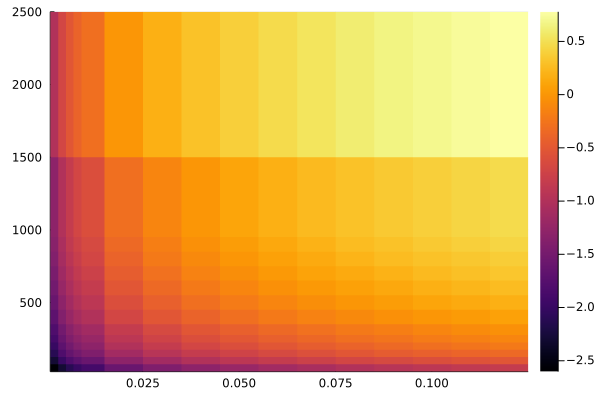

In [3]:
gr()

rng = MersenneTwister(1337)

sds_in = Sds(1000, .04)
in_size = sds_in.size
all_rf_sparsity = vcat(collect(.2:.2:.8), collect(1.:1.:12.)) #, [15., 20.])
all_n_neurons = vcat(collect(50:50:250), collect(300:100:900), [1000, 2000]) #, [3000, 4000])

rf_sparsity = []
n_neurons = []
overlaps = []
overlap = zeros(in_size)
trials = 10

for i in all_rf_sparsity
    rf_size = round(Int, i * in_size / 100.)
    
    for j in all_n_neurons
        push!(rf_sparsity, i)
        push!(n_neurons, j)
        
        overlap .= 0
        for _ in 1:trials
            for _ in 1:j
                indices = sample(rng, 1:in_size, rf_size, replace=false, ordered=true)
                overlap[indices] .+= 1
            end
        end
        push!(overlaps, mean(overlap ./ trials))
    end
end

heatmap(all_rf_sparsity ./ 100, all_n_neurons, reshape(log10.(overlaps ./ sds_in.active_size), length(all_n_neurons), :))

In [11]:
mutable struct SpatialPooler
    sds_in::Sds
    sds_out::Sds
    
    rng::AbstractRNG 
    perm_threshold::Float64
    perm_increment::Float64
    perm_decrement::Float64
    
    max_boost_factor::Float64
    boost_lr::Float64
    boost::Vector{Float64}
    
    potential_synapses::Vector{Vector{Int}}
    weights::Matrix{Float64}
    synapses::BitMatrix
    
    potentials::Vector{Float64}
    winners::Vector{Int}
end

function SpatialPooler(
        ;
        sds_in::Sds, sds_out::Sds, seed::Int, rec_field::Union{Int, Float64},
        perm_threshold::Float64, perm_increment::Float64, perm_decrement::Float64,
        max_boost_factor::Float64, boost_lr::Float64
    )
    rng = MersenneTwister(seed)

    # Synapses
    rec_field = AbsOrRelativeValue(sds_in.active_size, rec_field)
    sds_rec_field = Sds(sds_in.size, rec_field.absolute)
    potential_synapses = [
        rand_sparse(rng, sds_rec_field)
        for _ in 1:sds_out.size
    ]
    weights = zeros(sds_in.size, sds_out.size)
    weights_non_zero = rand(rng, sds_rec_field.active_size, sds_out.size)
    for out_i in 1:sds_out.size
        s = potential_synapses[out_i]
        weights[s, out_i] = weights_non_zero[:, out_i]
    end
    synapses = weights .>= perm_threshold
    
    # Boosting related stats
    boost = ones(sds_out.size)
    
    # Computations output and intermediate results
    overlaps = zeros(sds_out.size)
    winners = []
    
    return SpatialPooler(
        sds_in, sds_out, rng, perm_threshold, perm_increment, perm_decrement,
        max_boost_factor, boost_lr, boost,
        potential_synapses, weights, synapses,
        overlaps, winners
    )
end

function update_boost!(sp::SpatialPooler)
    # increase boosting for everyone
    sp.boost .*= 1 / (1 - boost_lr)
    
    # decrease boosting for the winners (double effect is to neutralize the previous operation)
    sp.boost[sp.winners] .*= (1 - boost_lr) ^ 2
    
    clamp!(sp.boost, 1 / sp.max_boost_factor, sp.max_boost_factor)
end

function compute_overlaps(sp::SpatialPooler, input_sdr::Vector{Int})::Vector{Int}
    overlaps = sum(sp.synapses[input_sdr, :], dims=1)
    # drop summed dim as it was kept
    overlaps = dropdims(overlaps, dims=1)
    
    return overlaps .* sp.boost
end

function compute_winners(sp::SpatialPooler, potentials::Vector{Float64})::Vector{Int}
    winners_unsorted = partialsortperm(sp.potentials, 1:sp.sds_out.active_size, rev=true)
    return sort(winners_unsorted)
end


function update_potentials!(sp::SpatialPooler, potentials::Vector{Float64})
    sp.potentials = potentials
end

function stdp_step!(sp::SpatialPooler, input_sdr::Vector{Int}, winners::Vector{Int})
    for winner in winners
        potential_synapses = sp.potential_synapses[winner]
        
        sp.weights[potential_synapses, winner] .-= sp.perm_decrement
        # here we increment also weights outside potential synapses
        sp.weights[input_sdr, winner] .+= sp.perm_increment

        sp.weights[potential_synapses, winner] = clamp.(sp.weights[potential_synapses, winner], 0., 1.)
        
        # it's crucial to consider only potential synapses 
        sp.synapses[potential_synapses, winner] = sp.weights[potential_synapses, winner] .>= sp.perm_threshold
    end
end

function compute!(sp::SpatialPooler, input_sdr::Vector{Int})::Vector{Int}
    overlaps = compute_overlaps(sp, input_sdr) * 1.0
    update_potentials!(sp, overlaps)
    
    sp.winners = compute_winners(sp, sp.potentials)
    stdp_step!(sp, input_sdr, sp.winners)
    
    return sp.winners
end

sp = SpatialPooler(
    sds_in = Sds(20, 5), sds_out = Sds(30, 4), seed = 42, rec_field = 2.5,
    perm_threshold = 0.5, perm_increment = 0.1, perm_decrement = 0.01,
    max_boost_factor = 1.5, boost_lr = 1e-3
)
input_sdr = rand_sparse(MersenneTwister(1337), sp.sds_in)
compute!(sp, input_sdr)

4-element Vector{Int64}:
  3
 10
 13
 14

## Simple performance check

In [12]:
sp = SpatialPooler(
    sds_in = Sds(2000, .05), sds_out = Sds(2000, .02), seed = 42, rec_field = 2.5,
    perm_threshold = 0.5, perm_increment = 0.1, perm_decrement = 0.01,
    max_boost_factor = 1.5, boost_lr = 1e-3
)
rng = MersenneTwister(1337)
input_sdr = rand_sparse(rng, sp.sds_in)
compute!(sp, input_sdr)

40-element Vector{Int64}:
   20
   49
  128
  224
  230
  248
  273
  318
  361
  367
  382
  386
  528
    ⋮
 1155
 1338
 1347
 1408
 1422
 1442
 1447
 1466
 1477
 1569
 1604
 1741

In [13]:
@benchmark compute!(sp, rand_sparse(rng, sp.sds_in))

BenchmarkTools.Trial: 6068 samples with 1 evaluation.
 Range (min … max):  727.375 μs …  15.729 ms  ┊ GC (min … max): 0.00% … 94.53%
 Time  (median):     772.125 μs               ┊ GC (median):    0.00%
 Time  (mean ± σ):   822.751 μs ± 579.273 μs  ┊ GC (mean ± σ):  5.19% ±  6.83%

            ▃▆▇██▄▃                                              
  ▁▁▁▁▂▂▂▄▅▇████████▆▅▄▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁ ▃
  727 μs           Histogram: frequency by time          915 μs <

 Memory estimate: 474.72 KiB, allocs estimate: 295.